In [31]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [18]:
image_width = 450
image_height = 600
batch = 32
channels = 3
train_size = 0.8
test_size = 0.1
epochs = 20

In [3]:
leafs_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\Medicinal Plant Identification\Indian Medicinal Leaves Image Datasets\Smaller Leaf dataset", shuffle=True, image_size=(image_width,image_height), batch_size=batch)

Found 624 files belonging to 6 classes.


In [4]:
leafs_classes= leafs_dataset.class_names
# plant_classes = plants_dataset.class_names
leafs_classes

['Aloevera', 'Insulin', 'Mint', 'Tulsi', 'Turmeric', 'camphor']

(16, 450, 600, 3)
[2 0 2 2 1 1 2 2 4 0 1 3 1 0 1 1]


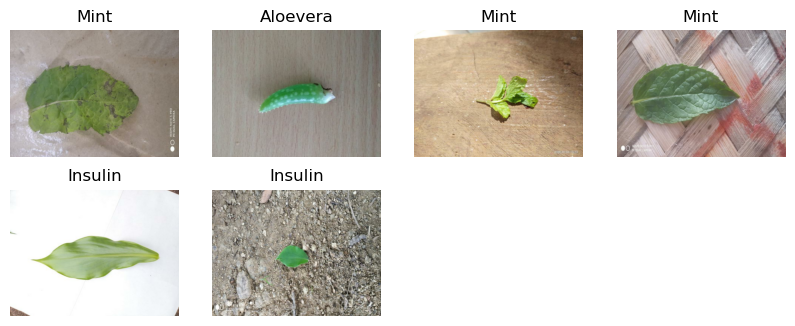

In [5]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in leafs_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range (6):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(leafs_classes[labels_batch[i]])
        plt.axis('off')

In [6]:
print(len(leafs_dataset)*train_size)
print(len(leafs_dataset)*test_size)

31.200000000000003
3.9000000000000004


In [7]:
def get_dataset(ds, train_split=0.7, val_split=0.15, test_split = 0.1, shuffle=True, shuffle_size=100):
  #assert(train_split+val_split+test_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12) 

  train_size = int(train_split*ds_size)
  valid_size = int(val_split*ds_size)
  leafs_train_dataset = ds.take(train_size)
  leafs_val_dataset = ds.skip(train_size).take(valid_size)
  leafs_test_dataset = ds.skip(train_size).skip(valid_size)
  
  return leafs_train_dataset, leafs_val_dataset, leafs_test_dataset

In [11]:
train_ds, val_ds, test_ds = get_dataset(leafs_dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

27
5
7


In [12]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 450, 600, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [13]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(image_width,image_height)
])


data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [19]:
input_shape = (batch, image_width,image_height,channels)
n_classes = 6
model = models.Sequential([
    resize_and_rescale,
    data_aug,
    #convolutional layers
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(48, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(48, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    #flattening layers
    layers.Flatten(),
    layers.Dense(48, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 450, 600, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 450, 600, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (32, 448, 598, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (32, 224, 299, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (32, 222, 297, 48)        13872     
                                                                 
 max_pooling2d_4 (MaxPoolin  (32, 111, 148, 48)        0         
 g2D)                                                 

In [21]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [22]:
history = model.fit(
    train_ds,
    batch_size = batch,
    validation_data = val_ds,
    verbose = 1,
    epochs = epochs
)

Epoch 1/20
27/27 [==============================] - 175s 6s/step - loss: 2.1660 - accuracy: 0.2477 - val_loss: 1.6030 - val_accuracy: 0.4375
Epoch 2/20
27/27 [==============================] - 151s 5s/step - loss: 1.6704 - accuracy: 0.2523 - val_loss: 1.6395 - val_accuracy: 0.2625
Epoch 3/20
27/27 [==============================] - 144s 5s/step - loss: 1.5693 - accuracy: 0.3449 - val_loss: 1.5139 - val_accuracy: 0.3750
Epoch 4/20
27/27 [==============================] - 177s 6s/step - loss: 1.4656 - accuracy: 0.3866 - val_loss: 1.3966 - val_accuracy: 0.3875
Epoch 5/20
27/27 [==============================] - 147s 5s/step - loss: 1.4679 - accuracy: 0.3889 - val_loss: 1.3988 - val_accuracy: 0.4750
Epoch 6/20
27/27 [==============================] - 141s 5s/step - loss: 1.4328 - accuracy: 0.4352 - val_loss: 1.1793 - val_accuracy: 0.5375
Epoch 7/20
27/27 [==============================] - 144s 5s/step - loss: 1.3456 - accuracy: 0.4931 - val_loss: 1.1511 - val_accuracy: 0.5250
Epoch 8/20
27

In [23]:
scores = model.evaluate(test_ds)
scores

7/7 [==============================] - 16s 1s/step - loss: 0.7175 - accuracy: 0.7679


[0.717501699924469, 0.7678571343421936]

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

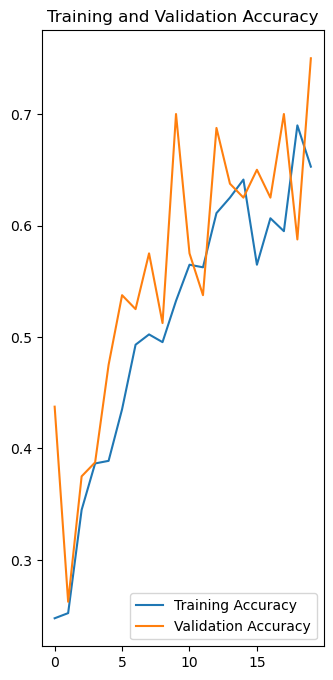

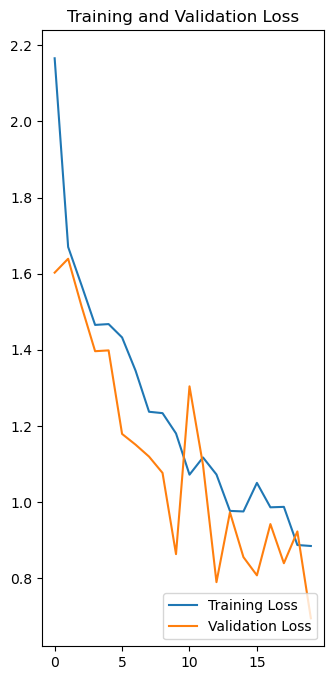

In [27]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label:  camphor
1/1 [==============================] - 1s 1s/step
Predicted Label:  camphor


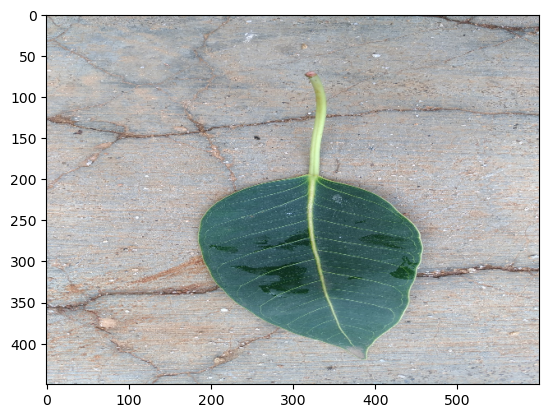

In [34]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", leafs_classes[first_label])

    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ',leafs_classes[np.argmax(batch_prediction[0])])